In [1]:
import cv2
from easy_ViTPose import VitInference
import matplotlib.pyplot as plt
import os
import numpy as np
from huggingface_hub import hf_hub_download

/cluster/tufts/fuzzywuzzy/jbrand12/condaenv/fzwz/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_SIZE = 'b'
YOLO_SIZE = 'n'
DATASET = 'apt36k'
ext = '.pth'
ext_yolo = '.pt'

In [3]:
MODEL_TYPE = "torch"
YOLO_TYPE = "torch"
REPO_ID = 'JunkyByte/easy_ViTPose'
FILENAME = os.path.join(MODEL_TYPE, f'{DATASET}/vitpose-' + MODEL_SIZE + f'-{DATASET}') + ext
FILENAME_YOLO = 'yolov8/yolov8' + YOLO_SIZE + ext_yolo

print(f'Downloading model {REPO_ID}/{FILENAME}')
model_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME)
yolo_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME_YOLO)

In [5]:
# If you want to use MPS (on new macbooks) use the torch checkpoints for both ViTPose and Yolo
# If device is None will try to use cuda -> mps -> cpu (otherwise specify 'cpu', 'mps' or 'cuda')
# dataset and det_class parameters can be inferred from the ckpt name, but you can specify them.
model = VitInference(model_path, yolo_path, MODEL_SIZE, dataset=DATASET, device='cuda')

In [35]:
# Image to run inference RGB format
img = cv2.imread('red_lasers/new_sample_data/3-Feb-2016-294.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

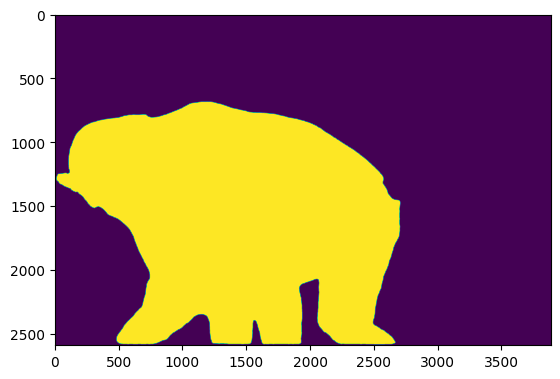

In [38]:
mask = cv2.imread('red_lasers/new_sample_data_masks/3-Feb-2016-294_mask.png', cv2.IMREAD_GRAYSCALE)  # Load mask in grayscale
mask = mask > 0  # need to convert to boolean values

# To select the inverse of the mask:
inverse_mask = np.logical_not(mask)

plt.imshow(mask)

In [64]:
# Now create a background which is a blurred version of the original image
blurred_background = cv2.GaussianBlur(img, (401, 401), 0)

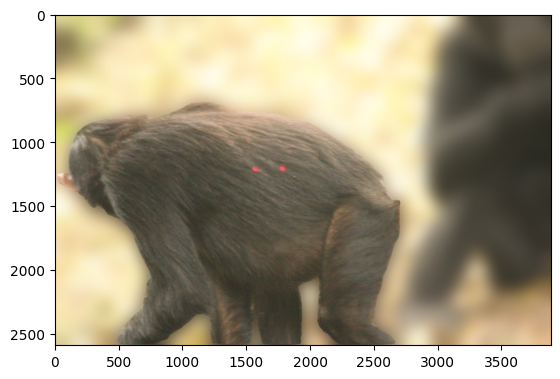

In [65]:
# Apply the mask
masked_im = np.zeros_like(img)
masked_im[mask] = img[mask]
masked_im[inverse_mask] = blurred_background[inverse_mask]
plt.imshow(masked_im)

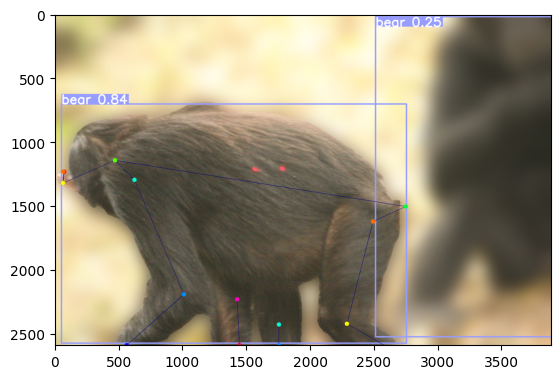

In [66]:
# Infer keypoints, output is a dict where keys are person ids and values are keypoints (np.ndarray (25, 3): (y, x, score))
# If is_video=True the IDs will be consistent among the ordered video frames.
keypoints = model.inference(masked_im)
output = model.draw(show_yolo=True)  # Returns RGB image with drawings
plt.imshow(output)

In [6]:
import json
# path to json file
json_file = 'red_lasers/im_data.json'

# folder containing images
image_folder = 'red_lasers/new_sample_data'

# load data
with open(json_file, 'r') as file:
    image_data = json.load(file)

In [7]:
def draw_dots(points, ax):
    ax.scatter(points[:, 0], points[:, 1], color='lightblue', s=5)

red_lasers/new_sample_data/3-Feb-2016-294.JPG [459, 1161] [2769, 1532]
red_lasers/new_sample_data/6-Oct-2015-186.JPG [1898, 811] [966, 1038]
red_lasers/new_sample_data/3-Feb-2016-565.JPG [1423, 1114] [2871, 1236]
red_lasers/new_sample_data/4-Feb-2016-247.JPG [2431, 1104] [1308, 1457]
red_lasers/new_sample_data/3-Nov-2015-417.JPG vitpose failed
red_lasers/new_sample_data/4-Dec-2015-4.JPG [1595, 114] [942, 1211]
red_lasers/new_sample_data/30-Oct-2015-157.JPG [555, 510] [1996, 870]
red_lasers/new_sample_data/10-Feb-2016-134.JPG [1131, 977] [2574, 1410]


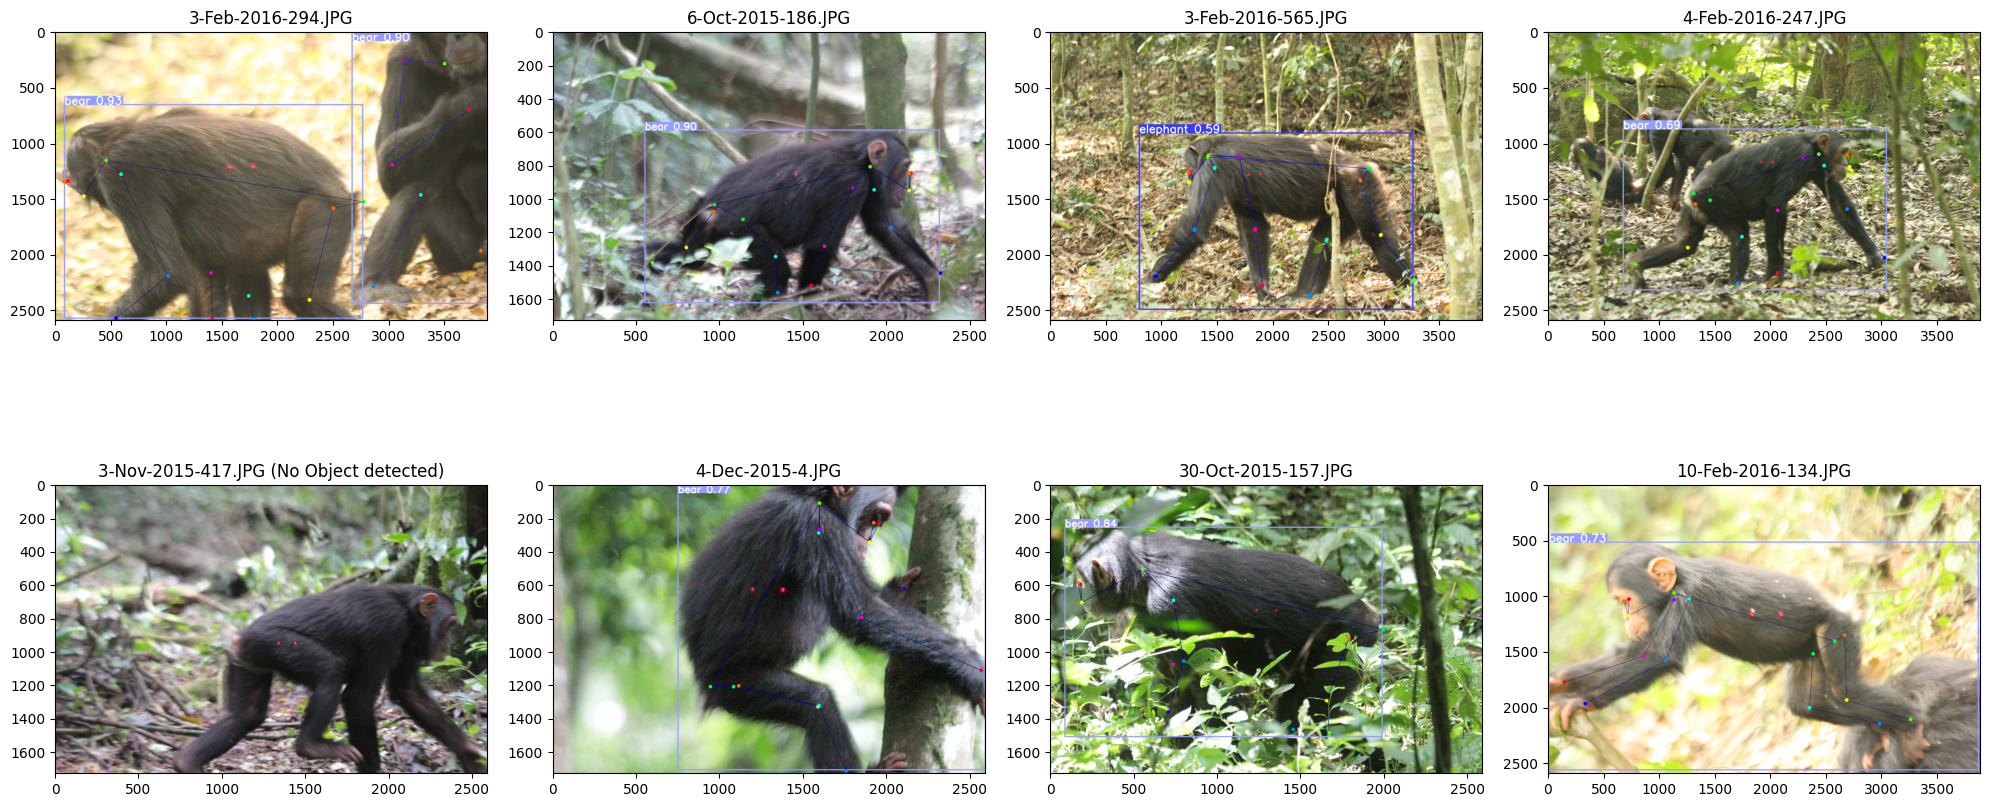

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# flatten axes for easy indexing
axs = axs.flatten()

idx = 0

# iterate through each entry in json
for image_name, info in image_data.items():
    image_path = os.path.join(image_folder, image_name)
    print(image_path, end=' ')
    # load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

    img_arr = np.array(img, dtype=np.uint8)
    keypoints = model.inference(img_arr)

    if keypoints:
      shoulder = keypoints[0][3]
      shoulder = [int(shoulder[1]), int(shoulder[0])]

      rump = keypoints[0][4]
      rump = [int(rump[1]), int(rump[0])]

      # draw results
      img = model.draw(show_yolo=True)
      axs[idx].set_title(image_name)

      # Update the JSON data with shoulder and rump
      image_data[image_name]['shoulder'] = shoulder
      image_data[image_name]['rump'] = rump
      print(shoulder, rump)
    else:
      print("vitpose failed")
      image_data[image_name]['shoulder'] = [0, 0]
      image_data[image_name]['rump'] = [0, 0]
      axs[idx].set_title(f"{image_name} (No Object detected)")

    axs[idx].imshow(img)
    idx+=1

plt.tight_layout()
plt.show()

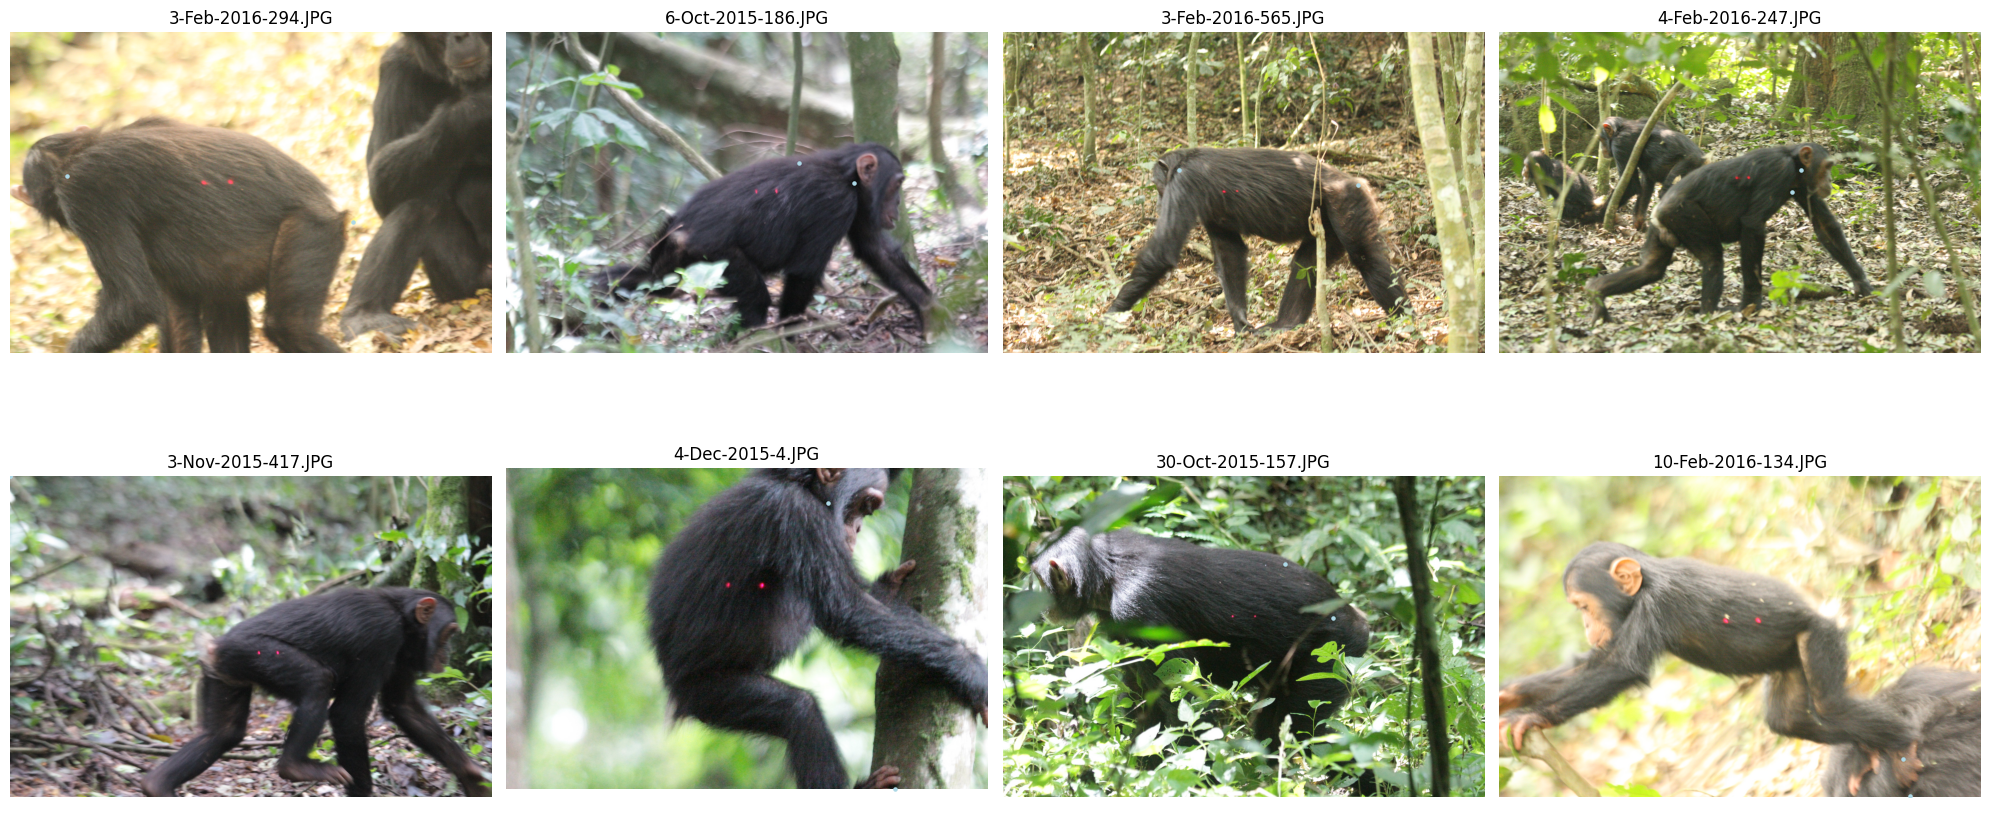

In [71]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# flatten axes for easy indexing
axs = axs.flatten()

idx = 0
# iterate through each entry in json
for image_name, info in image_data.items():
    image_path = os.path.join(image_folder, image_name)
    # load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

    if img is not None:
        # extract coordinates
        points = np.array([info['shoulder'], info['rump']])

        # plot image
        axs[idx].imshow(img)
        if len(points != 0):
            draw_dots(points, axs[idx])
            axs[idx].set_title(image_name)
        else:
            axs[idx].set_title(f"{image_name} (No points detected)")
        axs[idx].axis('off')

        idx += 1
    else:
        print(f"Could not load image: {image_name}")

plt.tight_layout()
plt.show()